In [1]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 6.1 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.special import factorial
from scipy.constants import hbar
import matplotlib.animation as animation
from qutip import *
import torch
import scipy.linalg as la

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [4]:
def qutip_to_torch(qobj):
  return torch.tensor(qobj.data.todense(), dtype = torch.cfloat)

def qutip_to_numpy(qobj):
  return np.array(qobj.data.todense(), dtype = np.cdouble)

def torch_to_qutip_op(tensor):
  N = tensor.shape[0] // 2
  shape = [[N, 2], [N, 2]]
  return Qobj(inpt = tensor.detach().numpy(), dims = shape)

def torch_to_qutip_ket(tensor):
  N = tensor.shape[0] // 2
  shape = [[N, 2], [1, 1]]
  return Qobj(inpt = tensor.detach().numpy(), dims = shape)

def numpy_to_qutip(arr):
  N = arr.shape[0] // 2
  shape = [[N, 2], [N, 2]]
  return Qobj(inpt = arr, shape = shape)

In [5]:
def time_evolution_exact(state, H, t):
  #print("Hamiltonian:", H)
  result = torch_to_qutip_ket(torch.matrix_exp(-1.0j * qutip_to_torch(H) * t) @ qutip_to_torch(state))
  #print("Time evolution operator:", result)
  return result

In [7]:
class cvqIon:

    def __init__(self, mass, charge, trap_f, N, modes, psi):
        self.mass = mass
        self.charge = charge
        self.trap_f = trap_f
        self.N = N
        self.modes = modes

        if dims(psi)[0][-1] != 2:
            raise ValueError("Last mode should be qubit mode")

        self.psi_with_noise = psi
        self.psi_without_noise = psi
        self.times = [0]
        self.history_with_noise = [psi]
        self.history_without_noise = [psi]

        self.a_ops = []
        self.sigma_m = None
        self.sigma_z = None
        self.sigma_p = None
        self.identity = None
        self.c_ops = []
        self.h0 = None

        self.__create_a()
        self.__create_h0()

        # arbitrary noise parameters--should be taken as inputs once we determine how to model noise
        self.__add_collapse_operators(0, 0, 0.05, 0)

    def __create_a(self):
        """ Creates annihilation operators for qubit and motional modes in the order provided by initial psi
        """
        dim_list = dims(self.psi_with_noise)[0]  # List of dimensions of each mode
        ident = [qeye(dim) for dim in dim_list]  # List of operators to tensor
        for i in range(len(dim_list) - 1):  # Create annihilation operator for each mode (including qubit)
            op_list = ident[:i] + [destroy(dim_list[i])] + ident[
                                                              i + 1:]  # Create operator list for annihilation of each motional mode
            self.a_ops.append(tensor(op_list))  # Create annihilation operator for motional mode
        self.sigma_m = tensor(ident[:-1] + [destroy(dim_list[-1])])  # Construct sigma_m operator
        self.sigma_z = tensor(ident[:-1] + [sigmaz()])  # Construct sigma_z operator
        self.sigma_p = self.sigma_m.dag()
        self.identity = tensor(ident[:-1] + [qeye(dim_list[-1])])

    def __create_h0(self):
        """Creates free evolution / base hamiltonian
        """
        # Simple QHO at secular trap freqeuncy
        # todo: add higher order terms of trap potential
        total_h0 = 0
        for mode in range(0, self.modes):
            a = self.a_ops[mode]
            total_h0 += self.trap_f *(a * a.dag()-self.identity)
        self.h0 = total_h0

    def __add_collapse_operators(self, spontaneous_emission_rate, dephasing_rate, motional_heating_rate,
                                 motional_decay_rate):
        """Collapse operators for the master equation of a single atom and a harmonic oscillator
        Support ONE motional mode currently

        returns: list of collapse operators for master equation solution of atom + harmonic oscillator
        """
        rate = spontaneous_emission_rate
        if rate > 0.0:
            self.c_ops.append(np.sqrt(rate) * self.sigma_m)

        rate = dephasing_rate
        if rate > 0.0:
            self.c_ops.append(np.sqrt(rate) * self.sigma_z)
            rate = dephasing_rate

        rate = motional_decay_rate
        if rate > 0.0:
            self.c_ops.append(np.sqrt(rate) * self.a_ops[0])

        rate = motional_heating_rate
        if rate > 0.0:
            self.c_ops.append(np.sqrt(rate) * self.a_ops[0].dag())

    def lamb_dicke(self, wavelength, theta):
        """computes the Lamb Dicke parameter

        @ var wavelength: laser wavelength in meters
        @ var theta: laser projection angle in degrees

        returns: Lamb-Dicke parameter
        """
        k = 2. * np.pi / wavelength
        return k * np.sqrt(1 / (2 * self.mass * 2 * np.pi * self.trap_f)) * np.abs(np.cos(np.pi * theta / 180))

    # Following are CVQC operations to perform on ion object
    # Currently using interaction picture and mesolve
    # self.psi can be state vector or density matrix
    # todo: change alpha/sq/chi etc into experimental parameters

    def __apply_hamiltonian(self, H, tlist, noise=False, solver='me', e_ops=[], a_ops=[], args={}):
        """ Applies the given Hamiltonian over the given set of times with the given solver

        @ var H: the Hamiltonian under which the principal system is evolving
        @ var tlist: total time; input as float or list of floats
        @ mode: the solver to be used for the numerical solution
        @ e_ops: the expectation values to be calculated for each timestep
        @ args: any arguments to the time-dependent Hamiltonian terms

        returns present state of principal system with noisy evolution
        """
        # Construct an appropriate array of times
        if type(tlist) is not np.ndarray:
            tlist = np.linspace(0, tlist, 500)

        # Select the appropriate function for solving
        if solver == 'brme':
            solver_func = brmesolve
        elif solver == 'fmme':
            solver_func = fmmesolve
        else:
            solver_func = mesolve

        # Solve both with noise and without
        result_without_noise = mesolve(H, self.psi_without_noise, tlist, c_ops=[], e_ops=e_ops, args=args)
        result_with_noise = result_without_noise
        if noise:
            result_with_noise = solver_func(H, self.psi_with_noise, tlist, c_ops=self.c_ops, e_ops=e_ops, args=args)

        # Store the results and return the final result with noise
        if e_ops == []:
            self.psi_with_noise = result_with_noise.states[-1]
            self.psi_without_noise = result_without_noise.states[-1]
            self.times.extend([self.times[-1] + t for t in result_with_noise.times])
            self.history_with_noise.extend(result_with_noise.states)
            self.history_without_noise.extend(result_without_noise.states)

        return result_with_noise, result_without_noise

    def rsb_evo(self, mode: int, n: int, eta: float, phi: float, tlist: float, e_ops=[], solver='me'):
        """ Solves time evolution for n'th red sideband transition

        @ var mode: Mode of ion to perform operation on
        @ var n: n'th order of sideband
        @ var eta: Lamb-Dicke parameter
        @ var phi: Phase of laser
        @ var tlist: Total time; input as float or list of floats
        @ var e_ops: Expectation values to calculate
        @ var solver: Choose which QuTip solver to use (default mesolve())

        returns result: list of evolved states at each time in tlist
        """
        a = self.a_ops[mode]
        # Dipole coupling <g|E_0 * x|e>
        omegaR = 1  # What is OmegaR for our ion?
        # First RSB hamiltonian
        H = 1 / 2 * omegaR * eta ** n / factorial(n) * (
                    a ** n * self.sigma_p * np.exp(1j * phi) + a.dag() ** n * self.sigma_m * np.exp(-1j * phi))

        return self.__apply_hamiltonian(H, tlist, solver=solver, e_ops=e_ops)

    def bsb_evo(self, mode: int, n: int, eta: float, phi: float, tlist: float, e_ops=[], solver='me'):
        """ Solves time evolution for n'th blue sideband transition

        @ var mode: Mode of ion to perform operation on
        @ var n: n'th order of sideband
        @ var eta: Lamb-Dicke parameter
        @ var phi: Phase of laser
        @ var tlist: Total time; input as float or list of floats
        @ var e_ops: Expectation values to calculate
        @ var solver: Choose which QuTip solver to use (default mesolve())

        returns result: list of evolved states at each time in tlist
        """
        a = self.a_ops[mode]
        # Dipole coupling <g|E_0 * x|e>
        omegaR = 1
        H = 1 / 2 * omegaR * eta ** n / factorial(n) * (
                    a.dag() ** n * self.sigma_p * np.exp(1j * phi) + a ** n * self.sigma_m * np.exp(-1j * phi))

        return self.__apply_hamiltonian(H, tlist, solver=solver, e_ops=e_ops)

    def carrier_evo(self, mode: int, phi: float, theta: float, tlist: float, e_ops=[], solver='me'):
        """ Solves time evolution for n'th blue sideband transition

        @ var mode: Mode of ion to perform operation on
        @ var phi: Phase of laser
        @ var tlist: Total time; input as float or list of floats
        @ var e_ops: Expectation values to calculate
        @ var solver: Choose which QuTip solver to use (default mesolve())

        returns result: list of evolved states at each time in tlist
        """
        a = self.a_ops[mode]
        # Dipole coupling <g|E_0 * x|e>
        # omegaR = 1
        H = -theta*(self.sigma_p * np.exp(-1j * phi) + self.sigma_m * np.exp(1j * phi))/2

        return self.__apply_hamiltonian(H, tlist)

    def free_evo(self, mode: int, tlist: float, e_ops=[], solver='me'):
        """ Solves time evolution of psi under free hamiltonian

        @ var tlist: total time; input as float or list of floats

        returns result: list of evolved states at each time in tlist
        """
        return self.__apply_hamiltonian(self.h0, tlist, solver=solver, e_ops=e_ops)

    def disp_evo(self, mode: int, alpha: complex, tlist: float):
        """ Solves time evolution of psi under displacement hamiltonian

        @ var mode: Mode of ion to perform operation
        @ var alpha: Complex displacement parameter
        @ var tlist: Total time; input as float or list of floats

        returns result: list of evolved states at each time in tlist
        """

        a = self.a_ops[mode]
        H = alpha * a.dag() - np.conj(alpha) * a
        #print("Hamiltonian:", H)

        return self.__apply_hamiltonian(H, tlist)

    def sq_evo(self, mode: int, sq: complex, tlist: float):
        """ Solves time evolution of psi under squeezing hamiltonian

        @ var mode: Mode of ion to perform operation
        @ var sq: Complex squeeze factor
        @ var tlist: Total time; input as float or list of floats

        returns result: list of evolved states at each time in tlist
        """

        a = self.a_ops[mode]
        H = 1 / 2 * (np.conj(sq) * a * a - sq * a.dag() * a.dag())

        return self.__apply_hamiltonian(H, tlist)

    def phase_evo(self, mode: int, phi: float, tlist: float):
        """ Solves time evolution of psi under phase shift hamiltonian

        @ var mode: Mode of ion to perform operation
        @ var phi: Phase
        @ var tlist: Total time; input as float or list of floats

        returns result: list of evolved states at each time in tlist
        """

        a = self.a_ops[mode]
        H = -1j * phi * a.dag() * a

        return self.__apply_hamiltonian(H, tlist)

    def kerr_evo(self, mode: int, chi: float, tlist: float):
        """ Solves time evolution of psi under cross-Kerr hamiltonian

        @ var mode: Mode of ion to perform operation
        @ var chi: Kerr nonlinearity
        @ var tlist: total time; input as float or list of floats

        returns result: list of evolved states at each time in tlist
        """

        a = self.a_ops[mode]
        H = 1 / 2 * chi * a.dag() * a.dag() * a * a

        return self.__apply_hamiltonian(H, tlist)

    def bs_evo(self, mode1: int, mode2: int, theta: float, tlist: float):
        """Solves time evolution of psi under beamsplitter hamiltonian

        @ var mode1, mode2: Modes of ion to perform operation
        @ var theta: transmissivity of beam splitter
        @ var tlist: total time

        returns result: list of evolved states at each time in tlist
        """

        a = self.a_ops[mode1]
        b = self.a_ops[mode2]
        H = theta * (a.dag() * b - a * b.dag())

        return self.__apply_hamiltonian(H, tlist)

    def stark_evo(self, mode: int, tlist: float):
        """Solves time evolution of psi under AC Stark hamiltonian

        @ var mode: Mode of ion to perform operation
        @ var tlist: total time

        returns result: list of evolved states at each time in tlist
        """
        a = self.a_ops[mode]
        H = a.dag() * a * self.sigma_z

        return self.__apply_hamiltonian(H, tlist)

    def cntrl_disp_evo(self, mode: int, alpha: complex, tlist: float, phi=0):
        """Solves time evolution of psi under Control Displacement hamiltonian

        @ var mode: Mode of ion to perform operation
        @ var alpha: Complex displacement parameter
        @ var phi: Spin pauli phase
        @ var tlist: total time

        returns result: list of evolved states at each time in tlist
        """

        a = self.a_ops[mode]
        H = (alpha * a.dag() - np.conj(alpha) * a) * self.sigma_z  # (np.exp(1j * phi) * self.sigma_p + np.exp(-1j * phi) * self.sigma_m)

        return self.__apply_hamiltonian(H, tlist)

    def el_drive(self, noise: bool, noise_const: float, amp: float, phase: float, w: float, mode: int, tlist: float,
                 blackman=False, ramp_up=0, ramp_down=0, e_ops=[], solver='me'):
        """ Solves time evolution of psi under time-dependent classical electric drive field

        @ var amp: Amplitude of E-field
        @ var phase: Phase of E-field
        @ var w: E-field drive frequency
        @ var envelope: Amplitude modulation of E-field
        @ var tlist: total time; input as float or list of floats
        @ var solver: Choose which QuTip solver to use (default mesolve())
        @ var blackman: boolean specifying whether to use a Blackman window or a linear ramp-up/ramp-down
        @ var ramp_up: proportion of duration spent ramping up (must be non-negative and sum with ramp_down to at most 1 if blackman is False)
        @ var ramp_down: proportion of duration spent ramping down (must be non-negative and sum with ramp_up to at most 1 if blackman is False)
        @ var e_ops: Expectation values to calculate

        returns result: list of evolved states (or expectation values) at each time in tlist
        """

        # Find the duration (for the purpose of generating the ramp)
        T = np.max(tlist)

        a = self.a_ops[mode]

        a_ops = []

        # Rabi frequency due to an E-field drive near the trap secular frequency
        OmegaR = self.charge * amp * np.sqrt(1 / (8 * self.mass * self.trap_f))
        # OmegaR = 0.1
        d = w - self.trap_f
        s = w + self.trap_f

        h_d = OmegaR * a.dag()
        h_ddag = OmegaR * a
        h_s = OmegaR * a.dag()
        h_sdag = OmegaR * a

        h_dt = 'exp(-1j * (delta*t+phi))'
        h_ddagt = 'exp(1j * (delta*t+phi))'
        h_st = 'exp(-1j * (sigma*t+phi))'
        h_sdagt = 'exp(1j * (sigma*t+phi))'

        # Time-dependent Hamiltonian (without and with RWA)
        H = [[h_d, h_dt], [h_ddag, h_ddagt], [h_s, h_st], [h_sdag, h_sdagt]]
        H_rwa = [[h_d, h_dt], [h_ddag, h_ddagt]]
        args = {'delta': d, 'sigma': s, 'phi': phase, 'ramp_up': ramp_up, 'ramp_down': ramp_down, 'T': T}

        # Generate the ramping coefficient and prepend to each time-dependent term
        if not blackman:
            if ramp_up < 0 or ramp_down < 0 or ramp_up + ramp_down > 1:
                raise ValueError("Ramp-up and ramp-down must both be non-negative and sum to at most 1")

            rising_str = '(t <= ramp_up * T) * t / (ramp_up * T)'
            flat_str = '((t > ramp_up * T) & (t < (1 - ramp_down) * T))'
            falling_str = '(t >= (1 - ramp_down * T)) * (1 - (t - (1 - ramp_down) * T)) / (ramp_down * T)'
            ramp_str = '(' + rising_str + ' + ' + flat_str + ' + ' + falling_str + ') * '
            if ramp_up == 0 and ramp_down == 0:
                ramp_str = ''
        else:
            const_str = '7938 / 18608'
            cos2_str = '9240 / 18608 * cos(2 * pi * t / T)'
            cos4_str = '1430 / 18608 * cos(4 * pi * t / T)'
            ramp_str = '(' + const_str + ' - ' + cos2_str + ' + ' + cos4_str + ') * '

        # H_ramped = [[h, ramp_str + h_t] for [h, h_t] in H]
        H_ramped = [[h, ramp_str + h_t] for [h, h_t] in H_rwa]

        if noise:
            kappa = noise_const  # White noise constant
            a_ops = [[(a, a.dag()), ('{0}*(w >= 0)'.format(kappa), 'exp(1j*t)', 'exp(-1j*t)')]]  # White noise bath

        return self.__apply_hamiltonian(H_ramped, tlist, solver=solver, e_ops=e_ops, a_ops=a_ops, args=args)

    # Following are plotting function
    # todo: plot other functions, make robust to handling many motional modes

    def create_wigner_plot(self, psi, xvec, yvec, state = 0):
        """ Creates new Wigner plot figure of initial state

        @ var psi: list of states to plot (from mesolve)
        @ var xvec, yvec: List of x/y-coordinates to evaluate Wigner function at

        returns fig, ax: figure and axes created
        """
        fig, ax = plt.subplots()
        # W = wigner(psi.states[0].ptrace(0), xvec, xvec)  # Note: here we trace out qubit before plotting
        W = wigner(psi[state].ptrace(0), xvec, xvec)  # Note: here we trace out qubit before plotting
        wlim = abs(W).max()
        ax.contourf(xvec, yvec, W, 100, norm=mpl.colors.Normalize(-wlim, wlim), cmap=mpl.cm.get_cmap('RdBu'))
        return fig, ax

    def cont_wigner_plot(self, psi, fig, ax, xvec, yvec, frames, step, title=''):
        """Make animation of Wigner plot time evolution

        @ var psi: list of state of plot (from mesolve)
        @ var xvec, yvec: List of x/y-coordinates to evaluate Wigner function at
        @ vars fig, ax: Figure and axes to plot on (generated by create_plot())
        @ var title: add optional title to figure
        """
        ax.set_title(title)
        for n in range(0, frames - 1, step):
            plt.pause(.01)
            # W = wigner(psi.states[n].ptrace(0), xvec, yvec)
            W = wigner(psi[n].ptrace(0), xvec, yvec)
            wlim = abs(W).max()
            ax.contourf(xvec, yvec, W, 100, norm=mpl.colors.Normalize(-wlim, wlim), cmap=mpl.cm.get_cmap('RdBu'))
            plt.draw()

    def fidelity(self):
        """ Calculates the fidelity of the current state with noisy evolution relative to the alternative without noise

        returns the desired fidelity
        """
        return fidelity(self.psi_with_noise.ptrace(0), self.psi_without_noise.ptrace(0))

    def evolution_exact(self, H, t):
      state = self.psi_without_noise
      result_without_noise = time_evolution_exact(state, H, t)
      self.psi_without_noise = result_without_noise
      self.history_without_noise.extend([result_without_noise])

    def carrier_evo_exact(self, mode: int, phi: float, theta: float, t: float):
      """ Solves time evolution for n'th blue sideband transition

      @ var mode: Mode of ion to perform operation on
      @ var phi: Phase of laser
      @ var tlist: Total time; input as float or list of floats
      @ var e_ops: Expectation values to calculate
      @ var solver: Choose which QuTip solver to use (default mesolve())

      returns result: list of evolved states at each time in tlist
      """
      a = self.a_ops[mode]
      # Dipole coupling <g|E_0 * x|e>
      # omegaR = 1
      H = theta * (self.sigma_p * np.exp(-1j * phi) + self.sigma_m * np.exp(1j * phi))/2

      return self.evolution_exact(H, t)

    def cntrl_disp_evo_exact(self, mode: int, alpha: complex, t: float, phi=0):
        """Solves time evolution of psi under Control Displacement hamiltonian

        @ var mode: Mode of ion to perform operation
        @ var alpha: Complex displacement parameter
        @ var phi: Spin pauli phase
        @ var tlist: total time

        returns result: list of evolved states at each time in tlist
        """

        a = self.a_ops[mode]
        H = 1j * (alpha * a.dag() - np.conj(alpha) * a) * self.sigma_z  # (np.exp(1j * phi) * self.sigma_p + np.exp(-1j * phi) * self.sigma_m)

        return self.evolution_exact(H, t)

    def disp_evo_exact(self, mode: int, alpha: complex, t: float):
      """ Solves time evolution of psi under displacement hamiltonian

      @ var mode: Mode of ion to perform operation
      @ var alpha: Complex displacement parameter
      @ var tlist: Total time; input as float or list of floats

      returns result: list of evolved states at each time in tlist
      """

      a = self.a_ops[mode]
      H = 1j * (alpha * a.dag() - np.conj(alpha) * a)

      return self.evolution_exact(H, t)

In [8]:
mass = 1  # Mass of ion
q = 1  # Ion charge
N = 200  # Size of motional Hilbert space or number of Fock states
w_axial = 1  # Trap axial secular frequency
modes = 1  # Number of motional modes
psi_0 = tensor(fock(N, 0), (basis(2, 0)).unit()) # Initial state for cat state construction
ion = cvqIon(mass, q, w_axial, N, modes, psi_0) # cvqIon object to process into cat state
mode = 0

In [9]:
psi_0_qspi = tensor(fock(N, 0), (basis(2, 0)).unit())
ion_qspi = cvqIon(mass, q, w_axial, N, modes, psi_0_qspi)

ion_qspi.disp_evo_exact(mode, np.pi / np.sqrt(2), 1)
psi_qspi = ion_qspi.history_without_noise
print(psi_qspi[-1])

Quantum object: dims = [[200, 2], [1, 1]], shape = (400, 1), type = ket
Qobj data =
[[8.48054737e-02]
 [0.00000000e+00]
 [1.88389614e-01]
 [0.00000000e+00]
 [2.95921415e-01]
 [0.00000000e+00]
 [3.79535317e-01]
 [0.00000000e+00]
 [4.21556890e-01]
 [0.00000000e+00]
 [4.18799579e-01]
 [0.00000000e+00]
 [3.79809141e-01]
 [0.00000000e+00]
 [3.18897486e-01]
 [0.00000000e+00]
 [2.50461489e-01]
 [0.00000000e+00]
 [1.85461804e-01]
 [0.00000000e+00]
 [1.30283490e-01]
 [0.00000000e+00]
 [8.72625113e-02]
 [0.00000000e+00]
 [5.59592806e-02]
 [0.00000000e+00]
 [3.44774686e-02]
 [0.00000000e+00]
 [2.04694495e-02]
 [0.00000000e+00]
 [1.17407376e-02]
 [0.00000000e+00]
 [6.52033696e-03]
 [0.00000000e+00]
 [3.51301907e-03]
 [0.00000000e+00]
 [1.83941238e-03]
 [0.00000000e+00]
 [9.37426114e-04]
 [0.00000000e+00]
 [4.65647056e-04]
 [0.00000000e+00]
 [2.25726340e-04]
 [0.00000000e+00]
 [1.06906875e-04]
 [0.00000000e+00]
 [4.95195309e-05]
 [0.00000000e+00]
 [2.24546257e-05]
 [0.00000000e+00]
 [9.97632742e-06

0.9862107318175285


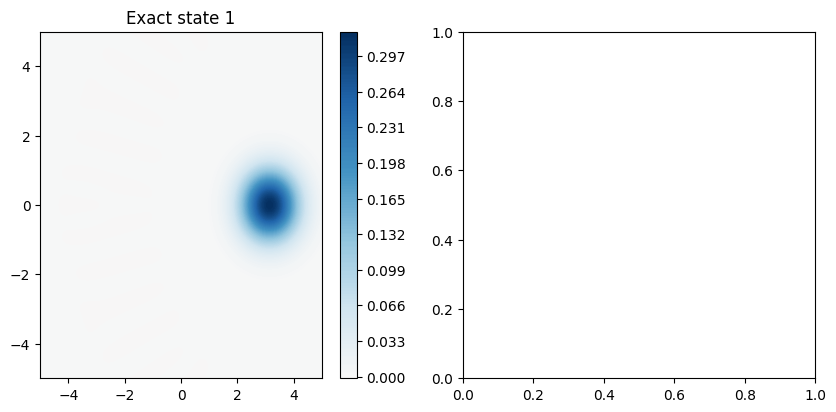

In [35]:
from matplotlib import cm

xvec = np.linspace(-5, 5, 200)
yvec = np.linspace(-5, 5, 200)

W1_qspi = wigner((psi_qspi[-1]).ptrace(0), xvec, yvec)
#W1_2_qspi = wigner((tensor(qeye(N), create(2)) * psi_2_qspi[-1]).ptrace(0), xvec, yvec)

print(np.sum(W1_qspi) / 400)
#print(np.sum(W1_2_qspi) / 400)

nrm1 = mpl.colors.Normalize(-W1_qspi.max(), W1_qspi.max())
#nrm2 = mpl.colors.Normalize(-W1_2_qspi.max(), W1_2_qspi.max())

#Wigner function
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

#plt0 = axes[0].contourf(xvec, xvec, Win0, 300, cmap = cm.RdBu, norm = nrm0)
#lbl0 = axes[0].set_title("Optimized state 1")
#cb0 = fig.colorbar(plt0, ax = axes[0])

plt1 = axes[0].contourf(xvec, xvec, W1_qspi, 300, cmap = cm.RdBu, norm = nrm1)
lbl1 = axes[0].set_title("Exact state 1")
cb1 = fig.colorbar(plt1, ax = axes[0])

#plt2 = axes[1].contourf(xvec, xvec, W1_2_qspi, 300, cmap = cm.RdBu, norm = nrm2)
#lbl2 = axes[1].set_title("mesolve state")
#cb2 = fig.colorbar(plt2, ax = axes[1])

savetitle = "20231116_corrected_exact_displacement_test_noF_pi_over_sqrt2.png"
plt.savefig("/content/drive/My Drive/GKP Project Figures/" + savetitle, dpi = 300, format = "png")
plt.show()

In [36]:
psi_0_qspi = tensor(fock(N, 0), (basis(2, 0) + basis(2, 1)).unit())
ion_qspi = cvqIon(mass, q, w_axial, N, modes, psi_0_qspi)

ion_qspi.cntrl_disp_evo_exact(mode, np.pi / np.sqrt(2), 1)
psi_qspi = ion_qspi.history_without_noise
print(psi_qspi[-1])

Quantum object: dims = [[200, 2], [1, 1]], shape = (400, 1), type = ket
Qobj data =
[[ 5.99665232e-02]
 [ 5.99665232e-02]
 [ 1.33211568e-01]
 [-1.33211568e-01]
 [ 2.09248036e-01]
 [ 2.09248036e-01]
 [ 2.68371999e-01]
 [-2.68371999e-01]
 [ 2.98085719e-01]
 [ 2.98085719e-01]
 [ 2.96136022e-01]
 [-2.96136022e-01]
 [ 2.68565625e-01]
 [ 2.68565625e-01]
 [ 2.25494564e-01]
 [-2.25494564e-01]
 [ 1.77103013e-01]
 [ 1.77103013e-01]
 [ 1.31141290e-01]
 [-1.31141290e-01]
 [ 9.21243355e-02]
 [ 9.21243355e-02]
 [ 6.17039129e-02]
 [-6.17039129e-02]
 [ 3.95691879e-02]
 [ 3.95691879e-02]
 [ 2.43792515e-02]
 [-2.43792515e-02]
 [ 1.44740865e-02]
 [ 1.44740865e-02]
 [ 8.30195472e-03]
 [-8.30195472e-03]
 [ 4.61057434e-03]
 [ 4.61057434e-03]
 [ 2.48407945e-03]
 [-2.48407945e-03]
 [ 1.30066089e-03]
 [ 1.30066089e-03]
 [ 6.62860344e-04]
 [-6.62860344e-04]
 [ 3.29262199e-04]
 [ 3.29262199e-04]
 [ 1.59612624e-04]
 [-1.59612624e-04]
 [ 7.55945730e-05]
 [ 7.55945730e-05]
 [ 3.50155969e-05]
 [-3.50155969e-05]
 [ 1

0.9862106953048135


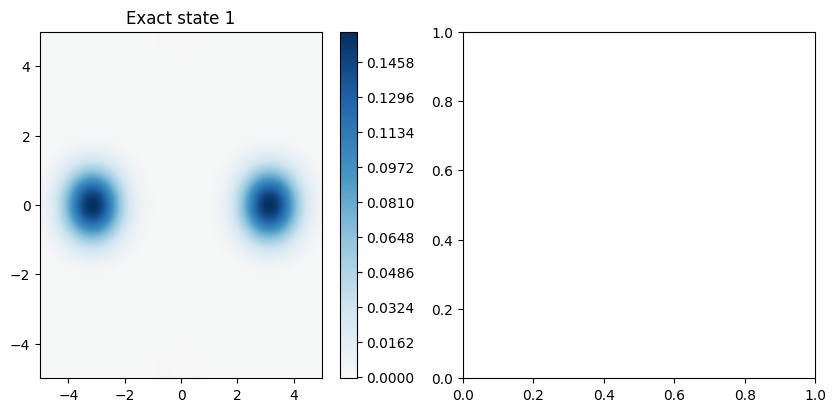

In [37]:
from matplotlib import cm

xvec = np.linspace(-5, 5, 200)
yvec = np.linspace(-5, 5, 200)

W1_qspi = wigner((psi_qspi[-1]).ptrace(0), xvec, yvec)
#W1_2_qspi = wigner((tensor(qeye(N), create(2)) * psi_2_qspi[-1]).ptrace(0), xvec, yvec)

print(np.sum(W1_qspi) / 400)
#print(np.sum(W1_2_qspi) / 400)

nrm1 = mpl.colors.Normalize(-W1_qspi.max(), W1_qspi.max())
#nrm2 = mpl.colors.Normalize(-W1_2_qspi.max(), W1_2_qspi.max())

#Wigner function
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

#plt0 = axes[0].contourf(xvec, xvec, Win0, 300, cmap = cm.RdBu, norm = nrm0)
#lbl0 = axes[0].set_title("Optimized state 1")
#cb0 = fig.colorbar(plt0, ax = axes[0])

plt1 = axes[0].contourf(xvec, xvec, W1_qspi, 300, cmap = cm.RdBu, norm = nrm1)
lbl1 = axes[0].set_title("Exact state 1")
cb1 = fig.colorbar(plt1, ax = axes[0])

#plt2 = axes[1].contourf(xvec, xvec, W1_2_qspi, 300, cmap = cm.RdBu, norm = nrm2)
#lbl2 = axes[1].set_title("mesolve state")
#cb2 = fig.colorbar(plt2, ax = axes[1])

savetitle = "20231116_corrected_exact_cntrl_disp_test_pi_over_sqrt2.png"
plt.savefig("/content/drive/My Drive/GKP Project Figures/" + savetitle, dpi = 300, format = "png")
plt.show()

In [38]:
k = 0.15 * np.sqrt(2)

psi_0_qspi = tensor(fock(N, 0), (basis(2, 0)).unit())
ion_qspi = cvqIon(mass, q, w_axial, N, modes, psi_0_qspi)
ion_qspi_2 = cvqIon(mass, q, w_axial, N, modes, psi_0_qspi)

ion_qspi.disp_evo_exact(mode, (0.375 * np.pi / k) / np.sqrt(2), 1)
ion_qspi_2.disp_evo(mode, (0.375 * np.pi / k) / np.sqrt(2), 1)

psi_qspi = ion_qspi.history_without_noise
psi_2_qspi = ion_qspi_2.history_without_noise

print(psi_qspi[-1])
print(psi_2_qspi[-1])

Quantum object: dims = [[200, 2], [1, 1]], shape = (400, 1), type = ket
Qobj data =
[[4.47397644e-04]
 [0.00000000e+00]
 [1.75962877e-03]
 [0.00000000e+00]
 [4.88542439e-03]
 [0.00000000e+00]
 [1.10770212e-02]
 [0.00000000e+00]
 [2.17491947e-02]
 [0.00000000e+00]
 [3.81966308e-02]
 [0.00000000e+00]
 [6.12358861e-02]
 [0.00000000e+00]
 [9.08908695e-02]
 [0.00000000e+00]
 [1.26192734e-01]
 [0.00000000e+00]
 [1.65186569e-01]
 [0.00000000e+00]
 [2.05132425e-01]
 [0.00000000e+00]
 [2.42883831e-01]
 [0.00000000e+00]
 [2.75338888e-01]
 [0.00000000e+00]
 [2.99885929e-01]
 [0.00000000e+00]
 [3.14739943e-01]
 [0.00000000e+00]
 [3.19129169e-01]
 [0.00000000e+00]
 [3.13304305e-01]
 [0.00000000e+00]
 [2.98402071e-01]
 [0.00000000e+00]
 [2.76201129e-01]
 [0.00000000e+00]
 [2.48833299e-01]
 [0.00000000e+00]
 [2.18500912e-01]
 [0.00000000e+00]
 [1.87242076e-01]
 [0.00000000e+00]
 [1.56765997e-01]
 [0.00000000e+00]
 [1.28365383e-01]
 [0.00000000e+00]
 [1.02896854e-01]
 [0.00000000e+00]
 [8.08149502e-02

In [39]:
k = 0.15 * np.sqrt(2)

psi_0_qspi = tensor(fock(N, 0), (basis(2, 0)).unit())
ion_qspi = cvqIon(mass, q, w_axial, N, modes, psi_0_qspi)
ion_qspi_2 = cvqIon(mass, q, w_axial, N, modes, psi_0_qspi)

ion_qspi.cntrl_disp_evo_exact(mode, 1j * k / np.sqrt(2), 1)
ion_qspi_2.cntrl_disp_evo(mode, 1j * k / np.sqrt(2), 1)

psi_qspi = ion_qspi.history_without_noise
psi_2_qspi = ion_qspi_2.history_without_noise

print(psi_qspi[-1])
print(psi_2_qspi[-1])

Quantum object: dims = [[200, 2], [1, 1]], shape = (400, 1), type = ket
Qobj data =
[[ 9.88813102e-01+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+1.48321956e-01j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-1.57319196e-02+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00-1.36242423e-03j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 1.02181817e-04+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+6.85456507e-06j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-4.19754656e-07+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00-2.37978508e-08j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 1.26207156e-09+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+6.31035779e-11j]
 [ 0.00000000e+00+0.00000000e+00j]
 [-2.99326601e-12+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00-1.35375543e-13j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 5.86193302e-15+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.0

In [42]:
# Phases for both the optimal QSPI state and the cat state for degrees 5, 9, and 13 with k = 0.15
k = 0.15 * np.sqrt(2)
#qspi_state_phase_list = [[3.53424467, 3.53731684, 6.28736476, 0.97696186, 3.65382249, 2.80176403, 3.4739108, 3.4831497, 5.27339552, 3.3720391, 2.25860482, 2.71654661, 3.04571734, 1.36224759], [2.29951063e+00, 5.44692069e-07, 5.25565913e+00, 3.14810245e+00, 5.73488206e+00, 6.28886041e+00, 1.10219726e+00, 8.54190371e-07, 3.68175473e+00, 8.66110002e-01], [2.3645263, 2.1434414, 3.1358502, 3.5574622, 3.1575634, 0.75503963]]
# cat_state_phase_list = [[np.pi / 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [np.pi / 4, 0, 0, 0, 0, 0, 0, 0, 0, 0], [np.pi / 4, 0, 0, 0, 0, 0]]
#qspi_state_phase_list = [[3.92699082, 1.2827791]]

#qspi_state_phase_list = [[3.51520638, 3.49773531, 6.28557359, 0.9997326, 3.66922981, 2.7845444, 3.58316684, 3.38466538, 5.29877696, 3.4152776, 2.16847087, 2.78526302, 3.00039577, -0.60511879]] #, [2.29287833e+00, 5.27992043e-07, 5.23464400e+00, 3.16089739e+00, 5.75171624e+00, 6.29745510e+00, 1.12519123e+00, 8.10798972e-07, 3.66603384e+00, 8.82856109e-01], [2.35987264, 2.12652193, 3.14787306, 3.57758637, 3.15854806, 0.77501569]]
#qspi_state_phase_list = [[2.35987264, 2.12652193, 3.14787306, 3.57758637, 3.15854806, 0.77501569]]
#qspi_state_phase_list = [[3.51520638, 3.49773531, 6.28557359, 0.9997326, 3.66922981, 2.7845444, 3.58316684, 3.38466538, 5.29877696, 3.4152776, 2.16847087, 2.78526302, 3.00039577, -0.60511879]]

#qspi_state_phase_list = [[2.35987264, 2.12652193, 3.14787306, 3.57758637, 3.15854806, 0.77501569]]
#qspi_state_phase_list = [[2.29287833e+00, 5.27992043e-07, 5.23464400e+00, 3.16089739e+00, 5.75171624e+00, 1.42697928e-02, 1.12519123e+00, 8.10798972e-07, 3.66603384e+00, 8.82856109e-01]]
qspi_state_phase_list = [[3.51520638e+00, 3.49773531e+00, 2.38828282e-03, 9.99732600e-01, 3.66922981e+00, 2.78454440e+00, 3.58316684e+00, 3.38466538e+00, 5.29877696e+00, 3.41527760e+00, 2.16847087e+00, 2.78526302e+00, 3.00039577e+00, 5.67806652e+00]]

for phases_idx in range(len(qspi_state_phase_list)):

    psi_0_qspi = tensor(fock(N, 0), (basis(2, 0)).unit())
    ion_qspi = cvqIon(mass, q, w_axial, N, modes, psi_0_qspi)
    ion_qspi_2 = cvqIon(mass, q, w_axial, N, modes, psi_0_qspi)
    angles_qspi = qspi_state_phase_list[phases_idx]

    d = len(angles_qspi) - 1
    print("Angle 1:")
    ion_qspi.carrier_evo_exact(mode, 0, -2 * angles_qspi[0], 1)
    print("With exact evolution:", (ion_qspi.history_without_noise)[-1])
    ion_qspi_2.carrier_evo(mode, 0, -2 * angles_qspi[0], 1)
    print("With mesolve:", (ion_qspi_2.history_without_noise)[-1])

    #ion_qspi.cntrl_disp_evo_exact(mode, 1j * k / np.sqrt(2), 1)
    #print("With exact evolution:", (ion_qspi.history_without_noise)[-1])
    #ion_qspi_2.cntrl_disp_evo(mode, 1j * k / np.sqrt(2), 1)
    #print("With mesolve:", (ion_qspi_2.history_without_noise)[-1])

    for i in range(len(angles_qspi) - 1):
      print("Angle " + str(i + 2) + ":")
      # There is a factor of 2 because of the way we define qubit rotations in cvqi.py
      ion_qspi.cntrl_disp_evo_exact(mode, 1j * k / np.sqrt(2), 1)
      ion_qspi_2.cntrl_disp_evo(mode, 1j * k / np.sqrt(2), 1)
      ion_qspi.carrier_evo_exact(mode, 0, -2 * angles_qspi[i + 1], 1)
      ion_qspi_2.carrier_evo(mode, 0, -2 * angles_qspi[i + 1], 1)

'''
    print("Displacement:")
    ion_qspi.disp_evo_exact(mode, (0.125 * np.pi / k) / np.sqrt(2), 1)
    ion_qspi_2.disp_evo(mode, (0.125 * np.pi / k) / np.sqrt(2), 1)

    for i in range(len(angles_qspi) - 1, 0, -1):
        print("Angle " + str(i + 1) + ":")
        # There is a factor of 2 because of the way we define qubit rotations in cvqi.py
        ion_qspi.carrier_evo_exact(mode, 0, 2 * angles_qspi[i], 1)
        ion_qspi_2.carrier_evo(mode, 0, 2 * angles_qspi[i], 1)
        ion_qspi.cntrl_disp_evo_exact(mode, -1j * k / np.sqrt(2), 1)
        ion_qspi_2.cntrl_disp_evo(mode, -1j * k / np.sqrt(2), 1)
    ion_qspi.carrier_evo_exact(mode, 0, 2 * angles_qspi[0], 1)
    ion_qspi_2.carrier_evo(mode, 0, 2 * angles_qspi[0], 1)

'''
psi_qspi = ion_qspi.history_without_noise
psi_2_qspi = ion_qspi_2.history_without_noise

print(psi_qspi[-1])
print(psi_2_qspi[-1])

Angle 1:
With exact evolution: Quantum object: dims = [[200, 2], [1, 1]], shape = (400, 1), type = ket
Qobj data =
[[-0.93101525+0.j        ]
 [ 0.        -0.36498159j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j    

In [43]:
xvec = np.linspace(-4, 4, 10)
yvec = [0]

W1_qspi_test = wigner((tensor(qeye(N), create(2)) * psi_qspi[-1]).ptrace(0), xvec, yvec)

print(W1_qspi_test)

[[4.84597445e-09 9.50456606e-06 5.54264429e-04 3.60129823e-02
  2.44484886e-01 2.44484886e-01 3.60129823e-02 5.54264429e-04
  9.50456606e-06 4.84597445e-09]]


0.9541331937440464
0.5702262784010272


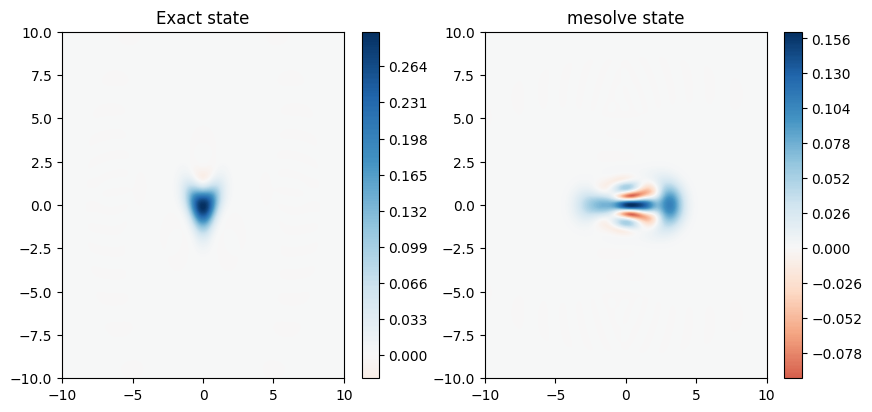

In [44]:
from matplotlib import cm

xvec = np.linspace(-10, 10, 400)
yvec = np.linspace(-10, 10, 400)

W1_qspi = wigner((tensor(qeye(N), create(2)) * psi_qspi[-1]).ptrace(0), xvec, yvec)
W1_2_qspi = wigner((tensor(qeye(N), create(2)) * psi_2_qspi[-1]).ptrace(0), xvec, yvec)

print(np.sum(W1_qspi) / 400)
print(np.sum(W1_2_qspi) / 400)

nrm1 = mpl.colors.Normalize(-W1_qspi.max(), W1_qspi.max())
nrm2 = mpl.colors.Normalize(-W1_2_qspi.max(), W1_2_qspi.max())

#Wigner function
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5))

#plt0 = axes[0].contourf(xvec, xvec, Win0, 300, cmap = cm.RdBu, norm = nrm0)
#lbl0 = axes[0].set_title("Optimized state 1")
#cb0 = fig.colorbar(plt0, ax = axes[0])

plt1 = axes[0].contourf(xvec, xvec, W1_qspi, 300, cmap = cm.RdBu, norm = nrm1)
lbl1 = axes[0].set_title("Exact state")
cb1 = fig.colorbar(plt1, ax = axes[0])

plt2 = axes[1].contourf(xvec, xvec, W1_2_qspi, 300, cmap = cm.RdBu, norm = nrm2)
lbl2 = axes[1].set_title("mesolve state")
cb2 = fig.colorbar(plt2, ax = axes[1])

savetitle = "20231116_new_evolution_comparison_d_13_20.png"
plt.savefig("/content/drive/My Drive/GKP Project Figures/" + savetitle, dpi = 300, format = "png")
plt.show()